<a href="https://colab.research.google.com/github/mwithgod3952/jh_Natural_language_processing/blob/main/RNN(Recurrent_Neural_Network).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload() 

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving RNN_Basics.jpg to RNN_Basics.jpg
User uploaded file "RNN_Basics.jpg" with length 304585 bytes


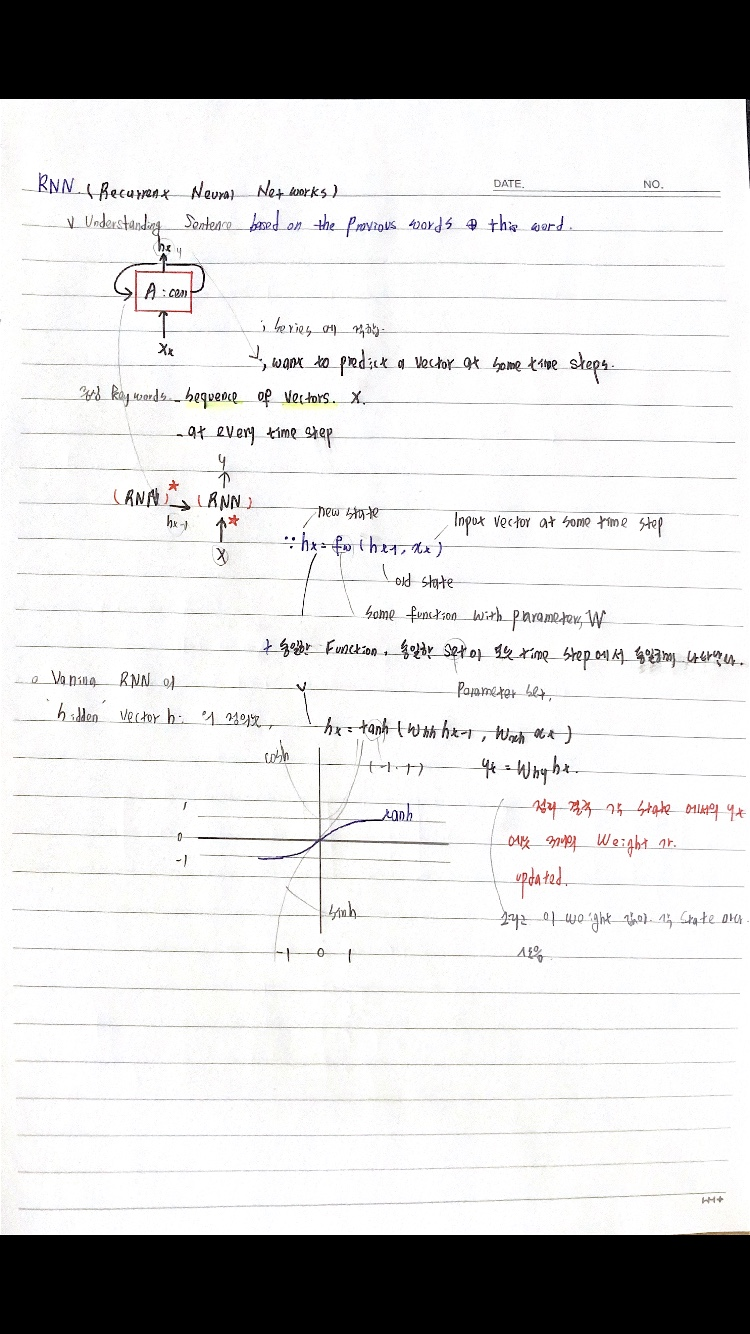

In [5]:
from IPython.display import Image
Image('RNN_Basics.jpg')

***RNN*** 

요점 : 

    - 편향 b도 입력으로 존재할 수 있음
    - 셀은 이전의 값을 기억하려고 하는 일종의 메모리 역할을 수행하므로 이를 메모리 셀 또는 RNN 셀이라고 표현
    - 재귀적 활동
    - 메모리 셀이 갖고 있는 이 값이 Hidden layer
    - 피드 포워드 신경망에서는 뉴런이라는 단위를 사용, but RNN에서는 뉴런이라는 단위보다는 
          * 입력층 출력층에서는 각각 입력 벡터와 출력 벡터, (Whh, Wxh) 
          * 은닉층에서는 은닉 상태라는 표현을 주로 사용 (Why)
    - 단어 벡터의 차원을 d라고 하고, 은닉 상태의 크기를 Dh라고 하였을 때,
          * h(Dh) = tanh(Dh*Dh*Dh   +   Dh*d*d   +   Dh) 
                            Wh*ht-1        Wx*xt      b

    -  활성화 함수로는 주로 하이퍼볼릭탄젠트 함수(tanh)가 사용되지만, ReLU로 바꿔 사용하는 시도도 있음
    - 각각의 가중치 Wx, Wh, Wy의 값은 모든 **시점에서 값을 동일하게 공유
    - but,  은닉층이 2개 이상일 경우에는 은닉층 2개의 가중치는 서로 다름.


**model.add(SimpleRNN(hidden_size, input_shape=(timesteps, input_dim)))**

**model.add(SimpleRNN(hidden_size, input_length=M, input_dim=N))** 

> *(출력층까지 포함한 하나의 완성된 인공 신경망 코드가 아니라 은닉층. 즉, RNN 층에 대한 코드)*

    - *** hidden_size = 은닉 상태의 크기를 정의. 
      메모리 셀이 다음 시점의 메모리 셀과 출력층으로 보내는 값의 크기기(output_dim)와도 동일 
            >> 중소형 모델의 경우 보통 128, 256, 512, 1024 등의 값을 가짐
    - timesteps = 입력 시퀀스의 길이(input_length)라고 표현하기도 함. 시점의 수.
    - input_dim = 입력의 크기.

    + many-to-one, many-to-many 코드구분 : time step=n, return_sequences=True                        


In [2]:
from keras.models import Sequential
from keras.layers import SimpleRNN

In [3]:
model = Sequential()
model.add(SimpleRNN(3, batch_input_shape=(8,2,10), return_sequences=True))
model.summary()

# batch_size, timesteps, output_dim)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (8, 2, 3)                 42        
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


      - the number of trainable parameters (weights and biases) in the respective layer = 3*3 + 3*10 + 3

      - recurrent_weights + input_weights + biases
          > ht=tanh(Wxxt+Whht−1+b)
          > (num_features + num_units) * num_units + num_units
                = (d * Dh) + (Dh * Dh) + Dh 

num_features = equals the number features of your **input**

recurrent_weights = num_units * num_units

input_weights = num_features * num_units

++ biases = num_units * 1

---

#### RNN 구현

In [5]:
import numpy as np

# 시점의 수, NLP에서는 보통 문장의 길이가 됨
timesteps = 10 

# 입력의 차원. NLP에서는 보통 단어 벡터의 차원이 됨
input_dim = 4 

# 은닉 상태의 크기. 메모리 셀의 용량이 됨
hidden_size = 8 

# 입력에 해당되는 2D 텐서 / 여기에 배치 사이즈가 붙으면 3D 텐서 >> 영상. Convolution에서는 channel 을 붙이기도 함
inputs = np.random.random((timesteps, input_dim)) 

# 초기 은닉 상태는 0(벡터)로 초기화
hidden_state_t = np.zeros((hidden_size,)) 

In [6]:
print(hidden_state_t)

[0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
Wx = np.random.random((hidden_size, input_dim))  
Wh = np.random.random((hidden_size, hidden_size))  
b = np.random.random((hidden_size,)) 

print(np.shape(Wx), "> (8, 4)크기의 2D 텐서 생성. 입력에 대한 가중치.")
print(np.shape(Wh) , "> (8, 8)크기의 2D 텐서 생성. 은닉 상태에 대한 가중치.")
print(np.shape(b), "> (8,)크기의 1D 텐서 생성. 이 값은 편향(bias)")

(8, 4) > (8, 4)크기의 2D 텐서 생성. 입력에 대한 가중치.
(8, 8) > (8, 8)크기의 2D 텐서 생성. 은닉 상태에 대한 가중치.
(8,) > (8,)크기의 1D 텐서 생성. 이 값은 편향(bias) >> 


In [10]:
total_hidden_states = []

for input_t in inputs:
  output_t = np.tanh(np.dot(Wx,input_t) + np.dot(Wh,hidden_state_t) + b)
  total_hidden_states.append(list(output_t))

  print(np.shape(total_hidden_states))
  hidden_state_t = output_t

(1, 8)
(2, 8)
(3, 8)
(4, 8)
(5, 8)
(6, 8)
(7, 8)
(8, 8)
(9, 8)
(10, 8)


In [11]:
total_hidden_states = np.stack(total_hidden_states, axis = 0) 
print(total_hidden_states)

[[0.91288864 0.9577105  0.73686143 0.93289656 0.89235447 0.89776056
  0.86200977 0.83720066]
 [0.99988591 0.99988329 0.99997716 0.99979454 0.99997279 0.9993455
  0.9997214  0.9993731 ]
 [0.99982667 0.99981915 0.99998391 0.99954609 0.99997631 0.99866611
  0.99941125 0.99894639]
 [0.99994463 0.99997669 0.99999017 0.99995438 0.99998689 0.99933435
  0.99973975 0.99987525]
 [0.99985833 0.99989019 0.99997779 0.99976195 0.99996767 0.99843292
  0.99938215 0.9993409 ]
 [0.99994896 0.99995809 0.99999252 0.99991475 0.99999066 0.99959574
  0.99984292 0.99979916]
 [0.99992941 0.99994438 0.99999137 0.99988242 0.9999882  0.99942013
  0.99975549 0.99972184]
 [0.99997014 0.999975   0.99999255 0.99996184 0.99999033 0.99969867
  0.99989033 0.99989566]
 [0.99975262 0.99974499 0.99997142 0.99933546 0.99995886 0.99776347
  0.99910126 0.9983131 ]
 [0.99990778 0.99995141 0.99997777 0.99990353 0.99997061 0.9987047
  0.9995509  0.99970412]]


In [20]:
# 문제풀이
# 단어 집합(Vocabulary)의 크기가 5,000
# 은닉 상태의 크기는 128
# 샘플의 길이는 30
# 출력층의 뉴런은 1개로 시그모이드 함수를 사용


# Wx = 128 * embadding_dim
# Wh = 128^2
# bias = 128 * 1
# Wy = 128

vocab_size = 5000
hidden_size = 128
outnum = 1

from keras.layers import Embedding
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(SimpleRNN(hidden_size))
model.add(Dense(outnum, activation='sigmoid'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         500000    
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 128)               29312     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 529,441
Trainable params: 529,441
Non-trainable params: 0
_________________________________________________________________


---

In [12]:
# Deep Recurrent Neural Network
model = Sequential()
model.add(SimpleRNN(hidden_size, return_sequences = True))
model.add(SimpleRNN(hidden_size, return_sequences = True))

In [ ]:
# Bidirectional Recurrent Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Bidirectional

model = Sequential()
model.add(Bidirectional(SimpleRNN(hidden_size, return_sequences = True), input_shape=(timesteps, input_dim)))

In [ ]:
# Deep Recurrent Neural Network + Bidirectional Recurrent Neural Network
model = Sequential()
model.add(Bidirectional(SimpleRNN(hidden_size, return_sequences = True), input_shape=(timesteps, input_dim)))
model.add(Bidirectional(SimpleRNN(hidden_size, return_sequences = True)))
model.add(Bidirectional(SimpleRNN(hidden_size, return_sequences = True)))
model.add(Bidirectional(SimpleRNN(hidden_size, return_sequences = True)))